<a href="https://colab.research.google.com/github/bettytan123/Sample-Size-Calculation/blob/main/Continuous_Mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
############################################
## This script will simulate data from known statistical distirbutions of one sample continuous mean; then estimate GAN and sample from it
## Final edit: 2023 July 5pm
## Authors: Betty and Chris, ft David
## Date: February 2023
############################################

In [ ]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv==0.18.0 --quiet
! pip install --upgrade scipy --quiet
! pip install sinfo --quiet
! pip install matplotlib==3.1.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 68.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.1.3 which is incompatible.
pandas-profiling 3.2.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.3 which is incompatible.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.1.3 which is incompatible.
copulas 0.8.0 requires matplotlib<4,>=3.4.0; python_version >= "3.7" and python_version < "3.10", but you have matplotlib 3.1.3 which is incompatible.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:

########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function
import scipy

## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU
import torch

# For plot/visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For take down the log in the loss plot
from io import StringIO
import sys

# Change color setting
sns.set_style('darkgrid')

In [ ]:
## Set seed of everything
np.random.seed(614)
torch.manual_seed(614)
random.seed(614)
scipy.stats.rv_continuous.random_state = 614

# Sample Size for Precision of a Continuous Normal Random Variable --- by Mathemtical Theory


In [ ]:
## Sample size by math formula
def samp_size_cont_ci(alpha, width, sigma):
    n = (4 * (scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)**2) * (sigma**2) ) / (width**2)
    return n

In [ ]:
# For testing the function build

In [ ]:
samp_size_cont_ci(alpha=0.05, width=0.6, sigma=1) # 42.68288

42.6828757854903

## Sample Size for Precision of a Continuous Normal Random Variable --- by numerical simulation


In [ ]:
## build the function to caculate sample size
def norm_ci_samp_size(n, mean, sd):
    ## Generate random data
    x = np.random.normal(loc=mean, scale = sd, size=n)
    ## Analyze generated/simulated data
    res = scipy.stats.ttest_1samp(x, popmean=mean, axis=0,
                        nan_policy='propagate',
                        alternative='two-sided')

    ## Extract the estimate and CI
    mu_ll, mu_ul = res.confidence_interval(0.95)
    mu_hat = np.mean(x)

    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'mean': [mu_hat],
                        'll95_mean': [mu_ll],
                        'ul95_mean': [mu_ul]})

    return(out)


In [ ]:
## Replicate above function number of simulation replicate times

# parameter available
n = int(np.ceil(samp_size_cont_ci(alpha=0.05, width=0.6, sigma=1)))
mean = 0
sd = 1

## Number simulation replicates
n_rep = 10000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(norm_ci_samp_size(n=n, mean=mean, sd=sd))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate means of each column in the array #axis means column mean
sim_means = np.mean(sim_df, axis=0)

#Calculate the width of the confidence interval
ci_width = sim_means[2] - sim_means[1]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    'mean_hat': [sim_means[0]],
    'mean_ll95': [sim_means[1]],
    'mean_ul95': [sim_means[2]],
    'ci_width': [ci_width]
})

sim_results

,runtime,mean_hat,mean_ll95,mean_ul95,ci_width
0,10.031784,-0.001517,-0.307174,0.304139,0.611313


## Sample size estimation by GAN simulation

In [ ]:
# model = CTGAN(verbose=True, epochs=200)
# model._model = model._build_model()
# model._set_random_state(42)

In [ ]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_normal(pop_mu, pop_sd, pop_n):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = np.random.normal(loc=pop_mu, scale=pop_sd, size=pop_n)

    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({"x": x})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    # CTGAN doesnt need to be seeded
    model = CTGAN(verbose=True, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)

    ## Return the learned model
    out = [model, x_pd]

    return out

  0%|          | 0/3 [00:00<?, ?it/s]

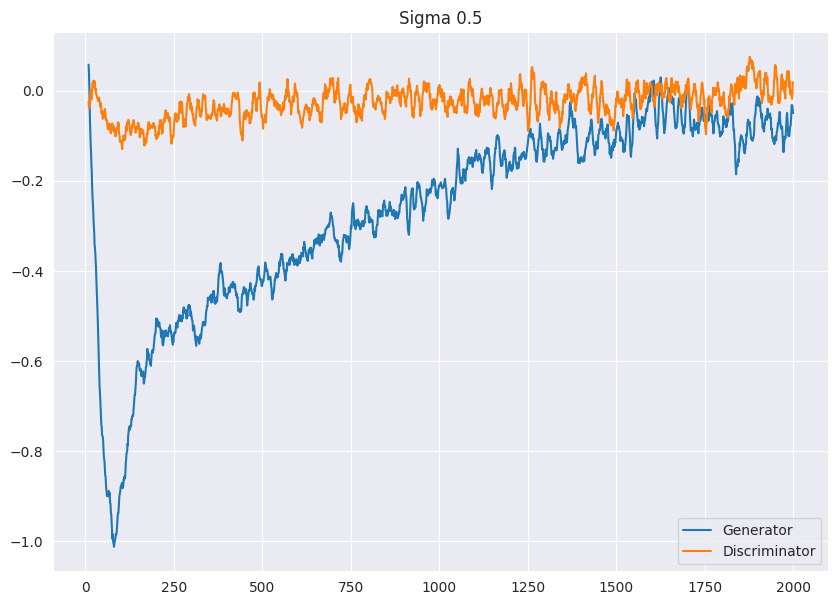

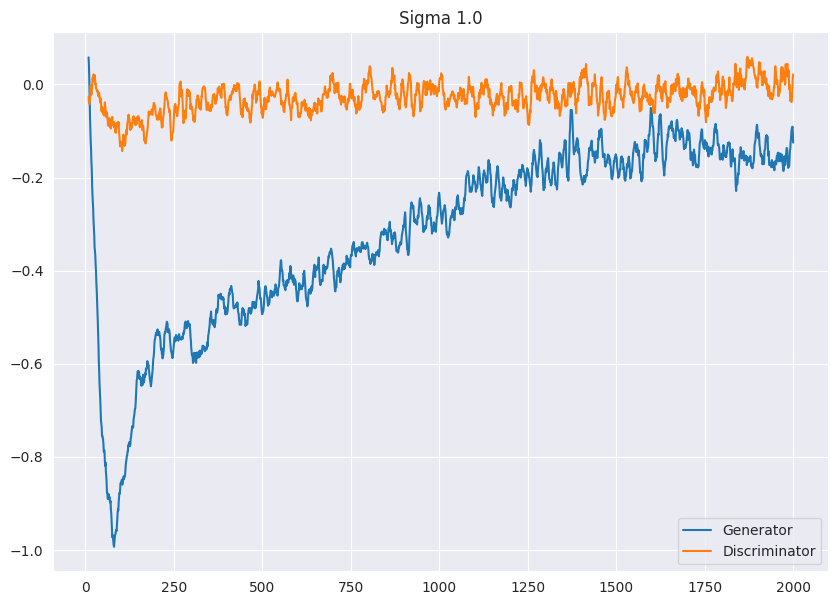

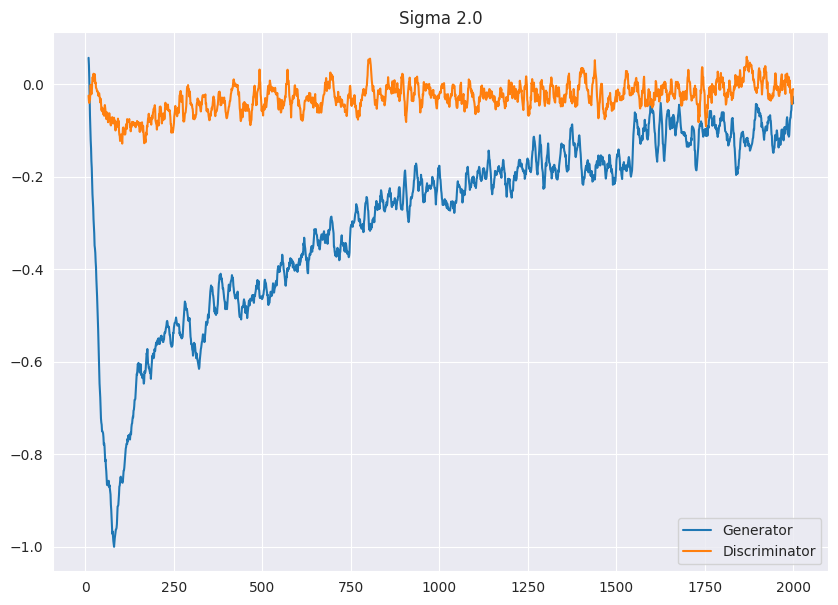

In [ ]:
sigmas = [0.5, 1.0, 2.0]
models = {}

# to build the loss plot logs to plot later
for sigma in tqdm(sigmas):
    path = f'logs-{sigma}.txt'
    sys.stdout = open(path, 'w')

    pop_n = 10_000
    pop_mu = 0.0

    ## Get the learned GAN model --- after training
    t0 = time()
    train_gan = train_gan_model_normal(pop_mu, sigma, pop_n)

    models[sigma] = train_gan[0]

    with open(f'logs-{sigma}.txt') as file:
        lines = file.readlines()

    output = "".join(lines)

    logs = StringIO(str(output))
    window = 10 # window size for the moving average, window=1 gets you the original series

    df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

    # I think a regex would be better here
    df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
    df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

    plt.figure(figsize=(10,7))

    # Plot with a moving average so it is less noisy
    plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
    plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

    plt.title(f'Sigma {sigma}')

    plt.legend()
    plt.show()

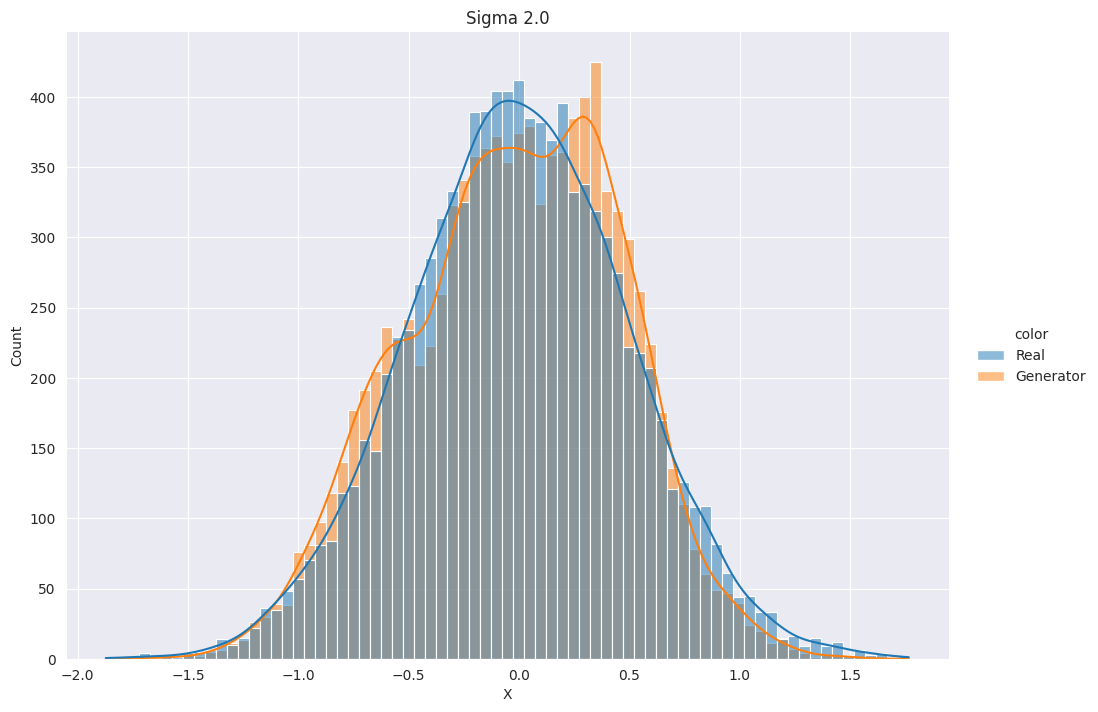

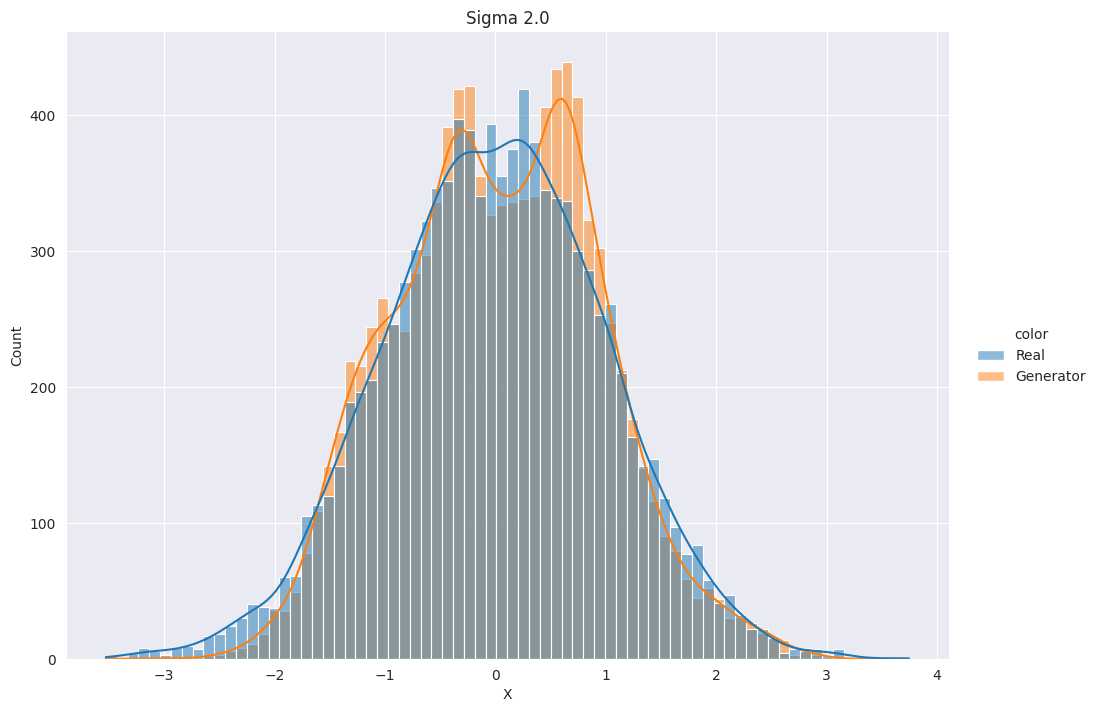

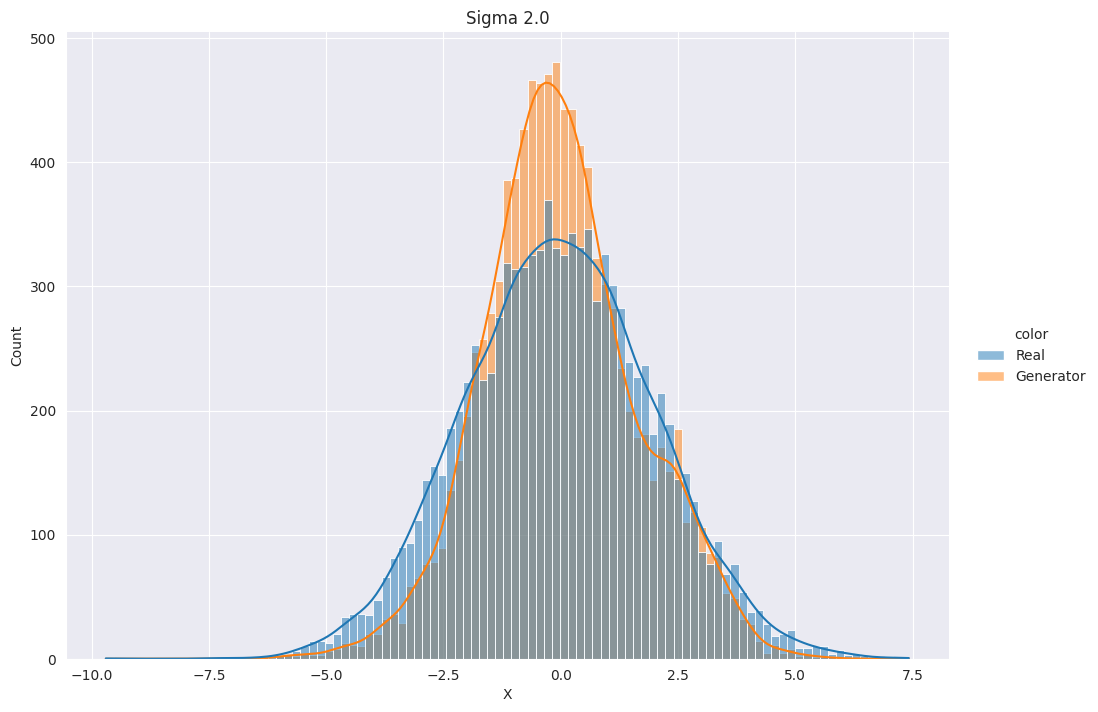

In [ ]:
# to build the distribution plot
for model, sd in zip(models.values(), sigmas):
    N = 10_000

    X_generator = model.sample(num_rows=N)
    X_real = np.random.normal(loc=0.0, scale=sd, size=N)
    data = pd.DataFrame(data={'X': list(X_real) + X_generator['x'].tolist() , 'color': N * ['Real'] + N * ['Generator']})

    sns.displot(data=data, x='X', kde=True, hue='color', height=7, aspect=1.4)
    plt.title(f'Sigma {sigma}')
    plt.show()

In [ ]:
## Function to analyze data from the sampled model
def norm_ci_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    x = m.sample(num_rows=sim_n)
    ## Analyze generated/simulated data
    res = scipy.stats.ttest_1samp(x, popmean=mu, axis=0, nan_policy='propagate', alternative='two-sided')

    ## Extract the estimate and CI
    mu_ll, mu_ul = res.confidence_interval(0.95)
    mu_hat = np.mean(x)

    # Return the estimate and the CI to the user
    out = pd.DataFrame({'mean': [mu_hat],
                         'll95_mean': [mu_ll],
                         'ul95_mean': [mu_ul]})
    return(out)

In [ ]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(norm_ci_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean
gan_means = np.mean(gan_df, axis=0)

## Calculate the width of the confidence interval
gan_width = gan_means[2] - gan_means[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'mean_hat': [gan_means[0]],
    'mean_ll95': [gan_means[1]],
    'mean_ul95': [gan_means[2]],
    'ci_width': [gan_width]
})

gan_results

,runtime,mean_hat,mean_ll95,mean_ul95,ci_width
0,13.560856,0.996528,0.833251,1.159805,0.326554


# Estimating sample size for a continuous CI from normal distribution

In [ ]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [ ]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

dictionary = {'alpha': [0.05],
              'mu': [0.0],
              'sigma': [0.5, 1.0, 2.0],
              'width': [0.05,0.1,0.25,0.5]} # changed 0.01 -> 0.05 to reduce training time

param_df = expand_grid(dictionary)
param_df

,alpha,mu,sigma,width
0,0.05,0.0,0.5,0.05
1,0.05,0.0,0.5,0.10
2,0.05,0.0,0.5,0.25
3,0.05,0.0,0.5,0.50
4,0.05,0.0,1.0,0.05
5,0.05,0.0,1.0,0.10
6,0.05,0.0,1.0,0.25
7,0.05,0.0,1.0,0.50
8,0.05,0.0,2.0,0.05
9,0.05,0.0,2.0,0.10


## Sample Size for Continuous CI by Theory or Analytic Formula

In [ ]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_cont_ci(alpha=param_df.loc[i, 'alpha'],
                          width=param_df.loc[i, 'width'],
                          sigma=param_df.loc[i, 'sigma'])
    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

samp_size_theory_df = pd.concat([param_df, pd.Series(samp_size_theory_list)], axis=1)
samp_size_theory_df.columns = ['alpha','mu','sigma','width','n_theory']
samp_size_theory_df

,alpha,mu,sigma,width,n_theory
0,0.05,0.0,0.5,0.05,1537.0
1,0.05,0.0,0.5,0.10,385.0
2,0.05,0.0,0.5,0.25,62.0
3,0.05,0.0,0.5,0.50,16.0
4,0.05,0.0,1.0,0.05,6147.0
5,0.05,0.0,1.0,0.10,1537.0
6,0.05,0.0,1.0,0.25,246.0
7,0.05,0.0,1.0,0.50,62.0
8,0.05,0.0,2.0,0.05,24586.0
9,0.05,0.0,2.0,0.10,6147.0


## Sample Size for Continuous CI by Simulation from Normal Distribution


In [ ]:
def norm_ci_samp_size(n, mean, sd):

    ## Generate random data
    x = np.random.normal(loc=mean, scale = sd, size=n)
    ## Analyze generated/simulated data
    res = scipy.stats.ttest_1samp(x, popmean=mean, axis=0,
                        nan_policy='propagate',
                        alternative='two-sided')

    ## Extract the estimate and CI
    mu_ll, mu_ul = res.confidence_interval(0.95)
    mu_hat = np.mean(x)

    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'mean': [mu_hat],
                        'll95_mean': [mu_ll],
                        'ul95_mean': [mu_ul]})

    return(out)


In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def norm_ci_samp_size_sim(n, mean, sd, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep, leave=False):
        sim_out.append(norm_ci_samp_size(n=n, mean=mean, sd=sd))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array
    sim_means = np.mean(sim_df, axis=0)

    ## Calculate the width of the confidence interval
    ci_width = sim_means[2] - sim_means[1]

    ## Return expect width
    return ci_width

In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 10000

t0 = time()

for i in trange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    ci_width = norm_ci_samp_size_sim(n=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
                          mean=samp_size_theory_df.loc[i, 'mu'],
                          sd=samp_size_theory_df.loc[i, 'sigma'],
                          n_rep=n_rep)
    ## Round to largest integer
    ci_width_ = str(np.round(ci_width,4))
    ## Append sample size to list
    samp_size_sim_list.append(ci_width_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
samp_size_sim_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_sim_list)], axis=1)
samp_size_sim_df.columns = ['alpha','mu','sigma','width','n_theory','ci_width_sim']
samp_size_sim_df

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

,alpha,mu,sigma,width,n_theory,ci_width_sim
0,0.05,0.0,0.5,0.05,1537.0,0.05
1,0.05,0.0,0.5,0.10,385.0,0.1002
2,0.05,0.0,0.5,0.25,62.0,0.2528
3,0.05,0.0,0.5,0.50,16.0,0.5247
4,0.05,0.0,1.0,0.05,6147.0,0.05
5,0.05,0.0,1.0,0.10,1537.0,0.1001
6,0.05,0.0,1.0,0.25,246.0,0.2508
7,0.05,0.0,1.0,0.50,62.0,0.5065
8,0.05,0.0,2.0,0.05,24586.0,0.05
9,0.05,0.0,2.0,0.10,6147.0,0.1


In [ ]:
## Timing for the simulation experiments
sim_time

160.3694944381714

## Sample Size for Continuous CI by Generative Adversarial Network (GAN) from a (parent) Normal Distribution


In [ ]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_normal(pop_mu, pop_sd, pop_n):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = np.random.normal(loc=pop_mu, scale=pop_sd, size=pop_n)

    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({"x": x})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=False, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)

    ## Return the learned model
    out = [model, x_pd]

    return out

In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def norm_ci_samp_size_gan(pop_n, pop_mu, pop_sd, sim_n, n_rep):

    ## Get the learned GAN model --- after training
    t0 = time()
    train_gan = train_gan_model_normal(pop_mu=pop_mu, pop_sd=pop_sd, pop_n=pop_n)
    t1 = time()
    fit_time = t1 - t0
    #fit_time

    ## Extract learned GAN model
    model_ = train_gan[0]

    ## Function to analyze data from the sampled model
    def norm_ci_samp_size_gan(m, sim_n):
        ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
        x = m.sample(num_rows=sim_n)
        ## Analyze generated/simulated data
        res = scipy.stats.ttest_1samp(x, popmean=mu, axis=0, nan_policy='propagate', alternative='two-sided')

        ## Extract the estimate and CI
        mu_ll, mu_ul = res.confidence_interval(0.95)
        mu_hat = np.mean(x)

        # Return the estimate and the CI to the user
        out = pd.DataFrame({'mean': [mu_hat],
                         'll95_mean': [mu_ll],
                         'ul95_mean': [mu_ul]})
        return(out)

    ##
    ## Replicate above function number of simulation replicate times
    ##

    ## Simulate n_rep copies of sample size trials
    gan_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        gan_out.append(norm_ci_samp_size_gan(m=model_, sim_n=sim_n))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean
    gan_means = np.mean(gan_df, axis=0)

    ## Calculate the width of the confidence interval
    gan_width = gan_means[2] - gan_means[1]

    ## Return the GAN estimated CI width
    return gan_width

In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def norm_ci_samp_size_gan(model, n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    x = model.sample(num_rows=n)
    ## Analyze generated/simulated data
    res = scipy.stats.ttest_1samp(x, popmean=0.0, axis=0, nan_policy='propagate', alternative='two-sided')

    ## Extract the estimate and CI
    mu_ll, mu_ul = res.confidence_interval(0.95)
    mu_hat = np.mean(x)

    # Return the estimate and the CI to the user
    out = pd.DataFrame({'mean': [mu_hat],
                        'll95_mean': [mu_ll],
                        'ul95_mean': [mu_ul]})
    return(out)

def norm_ci_samp_size_sim_gan(model, n, n_rep):

    ## Simulate n_rep copies of sample size trials
    gan_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep, leave=False):
        gan_out.append(norm_ci_samp_size_gan(model, n))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean
    gan_means = np.mean(gan_df, axis=0)

    ## Calculate the width of the confidence interval
    gan_width = gan_means[2] - gan_means[1]

    ## Return the GAN estimated CI width
    return gan_width

In [ ]:
####################
## Testting out to keep a record for wrong approach
####################
## WARNING...notice very subtle difference between pop_n and sim_n
##
## "sim_n" should be set to size of theoretical sample size needed to obtain CI of expected width, given SD/alpha/mean
##
## "pop_n" can vary...larger values mean GAN parent dist is more likely converge in dist to population model, smaller values reduce likelihood convergence in dist
##     --- larger values can also substantially increase training time for the GAN model
##

# t0 = time()

# tmp = norm_ci_samp_size_gan(pop_n=1000,
#                       pop_mu=0,
#                       pop_sd=1,
#                       sim_n=int(np.ceil(samp_size_cont_ci(alpha=0.05, width=0.6, sigma=1))),
#                       n_rep=1000)

# t1 = time()

# [tmp, t1-t0]

In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in trange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    sigma = np.float(samp_size_theory_df.loc[i, 'sigma'])

    if sigma in models:
        model = models[sigma]

        ci_width = norm_ci_samp_size_sim_gan(
            model,
            n=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
            n_rep=n_rep
        )

        ## Round to largest integer
        ci_width_ = str(np.round(ci_width,4))
        ## Append sample size to list
        samp_size_gan_list.append(ci_width_)

    else:
        samp_size_gan_list.append(np.nan)

t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
samp_size_gan_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_gan_list)], axis=1)
samp_size_gan_df.columns = ['alpha','mu','sigma','width','n_theory','ci_width_gan']
samp_size_gan_df

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,mu,sigma,width,n_theory,ci_width_gan
0,0.05,0.0,0.5,0.05,1537.0,0.0482
1,0.05,0.0,0.5,0.10,385.0,0.0966
2,0.05,0.0,0.5,0.25,62.0,0.243
3,0.05,0.0,0.5,0.50,16.0,0.507
4,0.05,0.0,1.0,0.05,6147.0,0.0461
5,0.05,0.0,1.0,0.10,1537.0,0.0921
6,0.05,0.0,1.0,0.25,246.0,0.231
7,0.05,0.0,1.0,0.50,62.0,0.4644
8,0.05,0.0,2.0,0.05,24586.0,0.0419
9,0.05,0.0,2.0,0.10,6147.0,0.0837


In [ ]:
samp_size_sim_df['ci_width_gan'] = samp_size_gan_df['ci_width_gan']
samp_size_sim_df

,alpha,mu,sigma,width,n_theory,ci_width_sim,ci_width_gan
0,0.05,0.0,0.5,0.05,1537.0,0.05,0.0482
1,0.05,0.0,0.5,0.10,385.0,0.1002,0.0966
2,0.05,0.0,0.5,0.25,62.0,0.2528,0.243
3,0.05,0.0,0.5,0.50,16.0,0.5247,0.507
4,0.05,0.0,1.0,0.05,6147.0,0.05,0.0461
5,0.05,0.0,1.0,0.10,1537.0,0.1001,0.0921
6,0.05,0.0,1.0,0.25,246.0,0.2508,0.231
7,0.05,0.0,1.0,0.50,62.0,0.5065,0.4644
8,0.05,0.0,2.0,0.05,24586.0,0.05,0.0419
9,0.05,0.0,2.0,0.10,6147.0,0.1,0.0837


In [ ]:
samp_size_sim_df

,alpha,mu,sigma,width,n_theory,ci_width_sim,ci_width_gan,ci_theory
0,0.05,0.0,0.5,0.05,1537.0,0.05,0.0482,0.5
1,0.05,0.0,0.5,0.10,385.0,0.1002,0.0966,0.5
2,0.05,0.0,0.5,0.25,62.0,0.2528,0.243,0.5
3,0.05,0.0,0.5,0.50,16.0,0.5247,0.507,0.5
4,0.05,0.0,1.0,0.05,6147.0,0.05,0.0461,1.0
5,0.05,0.0,1.0,0.10,1537.0,0.1001,0.0921,1.0
6,0.05,0.0,1.0,0.25,246.0,0.2508,0.231,1.0
7,0.05,0.0,1.0,0.50,62.0,0.5065,0.4644,1.0
8,0.05,0.0,2.0,0.05,24586.0,0.05,0.0419,2.0
9,0.05,0.0,2.0,0.10,6147.0,0.1,0.0837,2.0


In [ ]:
samp_size_sim_df['n_theory'] = samp_size_sim_df['n_theory'].astype(float)
samp_size_sim_df['ci_width_sim'] = samp_size_sim_df['ci_width_sim'].astype(float)
samp_size_sim_df['ci_width_gan'] = samp_size_sim_df['ci_width_gan'].astype(float)

In [ ]:
samp_size_sim_df['ci_theory'] = samp_size_sim_df['width']

# Build the final table with error rate
samp_size_sim_df['relative_error_sim'] = 100 * (samp_size_sim_df['ci_theory'] - samp_size_sim_df['ci_width_sim']).abs() /  samp_size_sim_df['ci_theory']
samp_size_sim_df['relative_error_gan'] = 100 * (samp_size_sim_df['ci_theory'] - samp_size_sim_df['ci_width_gan']).abs() /  samp_size_sim_df['ci_theory']

#Final table for comparasion
samp_size_sim_df


,alpha,mu,sigma,width,n_theory,ci_width_sim,ci_width_gan,ci_theory,relative_error_sim,relative_error_gan
0,0.05,0.0,0.5,0.05,1537.0,0.0500,0.0482,0.05,0.00,3.60
1,0.05,0.0,0.5,0.10,385.0,0.1002,0.0966,0.10,0.20,3.40
2,0.05,0.0,0.5,0.25,62.0,0.2528,0.2430,0.25,1.12,2.80
3,0.05,0.0,0.5,0.50,16.0,0.5247,0.5070,0.50,4.94,1.40
4,0.05,0.0,1.0,0.05,6147.0,0.0500,0.0461,0.05,0.00,7.80
5,0.05,0.0,1.0,0.10,1537.0,0.1001,0.0921,0.10,0.10,7.90
6,0.05,0.0,1.0,0.25,246.0,0.2508,0.2310,0.25,0.32,7.60
7,0.05,0.0,1.0,0.50,62.0,0.5065,0.4644,0.50,1.30,7.12
8,0.05,0.0,2.0,0.05,24586.0,0.0500,0.0419,0.05,0.00,16.20
9,0.05,0.0,2.0,0.10,6147.0,0.1000,0.0837,0.10,0.00,16.30


In [ ]:
gan_time

404.6443524360657

In [ ]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [ ]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-04-04'

In [ ]:
## Session Info
from sinfo import sinfo
sinfo()

In [ ]:
## Jupyter version
!jupyter --version

In [ ]:
## Python version
!python --version